<a href="https://colab.research.google.com/github/SMTorg/smt-explainability/blob/master/tutorial/Explainability_tools.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Surrogate based explainability tools with SMT

<div class="jumbotron text-left"><b>
The French Aerospace Lab ONERA <br/>
Information Processing and Systems Department (DTIS) <br/>
Multidisciplinary Methods, Integrated Concepts (M2CI) Research Unit <br/>
</div>

Paul Saves ONERA/DTIS
   
**Latest update:** Octover 2024 - `SMT version 2.7.0`

In this notebook, we present an example in order to use conformal prediction within the Toolbox SMT

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link: https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>


**Reference work by Sebastien Da Veiga** *Tutorial on conformal prediction & related methods* https://sites.google.com/view/sebastien-da-veiga/etics-2024-tutorial-on-conformal-prediction-related-methods, 

**Reference work by Daffa Robani et al** *SMT-EX: An Explainable Surrogate Modeling Toolbox for
Mixed-Variables Design Exploration* 

# Conformal Prediction
First, we present an example in order to use conformal prediction within the Toolbox SMT

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from smt.kernels import Constant
from smt.kernels import PowExp
from smt.surrogate_models import KRG

import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.use("tkagg")
%matplotlib inline 

In [2]:
# Quantile functions
def quantile_cp(z, alpha):
    n = len(z)
    q = np.sort(z)[int(np.ceil((1 - alpha) * (n + 1)) - 1)]
    return q


def quantile_cp_minus(z, alpha):
    n = len(z)
    q = np.sort(z)[int(np.floor(alpha * (n + 1)) - 1)]
    return q

### Data generation

In [3]:
# Function to generate random heteroskedastic data
def make_random_data(n, std_dev):
    x = np.random.uniform(-1, 1, n)
    y = x**3 + 2 * np.exp(-6 * (x - 0.3) ** 2)
    y = y + np.random.normal(0, std_dev * np.abs(x), n)
    return pd.DataFrame({"x": x, "y": y})


# Generate train and test data
np.random.seed(12345)
ntrain = 1000
ntest = 1000
nvisu = 1000
std_dev = 1 / 5
train_data = make_random_data(ntrain, std_dev)
test_data = make_random_data(ntest, std_dev)
visu_data = pd.DataFrame({"x": np.linspace(-1, 1, nvisu)})

In [4]:
# Sample split
ncal = 100
npretrain = ntrain - ncal
train_data = train_data.sample(frac=1).reset_index(drop=True)
pretrain_data = train_data.iloc[:npretrain]
cal_data = train_data.iloc[npretrain:]

alpha = 0.1

### Rescaled scores with GP

In [5]:
k = PowExp([0.01]) * Constant([0.01])


gp = KRG(corr="squar_exp", noise0=[1e-6], hyper_opt="Cobyla", n_start=20)

# Pretraining Gaussian Process
X_pretrain = pretrain_data["x"].values.reshape(-1, 1)
y_pretrain = pretrain_data["y"].values
gp.set_training_values(X_pretrain, y_pretrain)
gp.train()
gp_pred_pretrain = gp.predict_values(X_pretrain)[:, 0]
gp_std_pretrain = np.sqrt(gp.predict_variances(X_pretrain))[:, 0]

# Compute residuals and fit another GP on residuals
res_gp_pred_pretrain = np.abs(y_pretrain - gp_pred_pretrain)
gp_res = KRG(corr="squar_exp", noise0=[1e-6], hyper_opt="Cobyla", n_start=20)
gp_res.set_training_values(X_pretrain, res_gp_pred_pretrain)
gp_res.train()

# Predictions on calibration data
X_cal = cal_data["x"].values.reshape(-1, 1)
y_cal = cal_data["y"].values
gp_pred_cal = gp.predict_values(X_cal)[:, 0]
gp_std_cal = np.sqrt(gp.predict_variances(X_cal))[:, 0]
gp_res_pred_cal = gp_res.predict_values(X_cal)[:, 0]

res_gp_pred_cal = np.abs(y_cal - gp_pred_cal) / gp_res_pred_cal
gp_q_cal = quantile_cp(res_gp_pred_cal, alpha)

# Predictions for visualization data
X_visu = visu_data["x"].values.reshape(-1, 1)
gp_pred_visu = gp.predict_values(X_visu)[:, 0]
gp_std_visu = np.sqrt(gp.predict_variances(X_visu))[:, 0]
gp_res_pred_visu = gp_res.predict_values(X_visu)[:, 0]

# Compute lower and upper bounds for the GP with rescaling based on residuals
gp_pred = pd.DataFrame(
    {
        "x": visu_data["x"],
        ".pred": gp_pred_visu,
        ".pred_lower": gp_pred_visu - gp_res_pred_visu * gp_q_cal,
        ".pred_upper": gp_pred_visu + gp_res_pred_visu * gp_q_cal,
    }
)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 900
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 17.9421842
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 900
   
   Predicting ...
   Predicting - done. Time (sec):  0.0244651
   
   Prediction time/pt. (sec) :  0.0000272
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 900
   
___________________________________________________________________________
   
 Tr

In [6]:
# GP with rescaling from posterior standard deviation
gp_pred_cal2 = gp.predict_values(X_cal)[:, 0]
gp_std_cal2 = np.sqrt(gp.predict_variances(X_cal))[:, 0]
res_gp_pred_cal2 = np.abs(y_cal - gp_pred_cal2) / gp_std_cal2
gp_q_cal2 = quantile_cp(res_gp_pred_cal2, alpha)

gp_pred_visu2 = gp.predict_values(X_visu)[:, 0]
gp_std_visu2 = np.sqrt(gp.predict_variances(X_visu))[:, 0]

gp_pred2 = pd.DataFrame(
    {
        "x": visu_data["x"],
        ".pred": gp_pred_visu2,
        ".pred_lower": gp_pred_visu2 - gp_std_visu2 * gp_q_cal2,
        ".pred_upper": gp_pred_visu2 + gp_std_visu2 * gp_q_cal2,
    }
)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0035322
   
   Prediction time/pt. (sec) :  0.0000353
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0262229
   
   Prediction time/pt. (sec) :  0.0000262
   


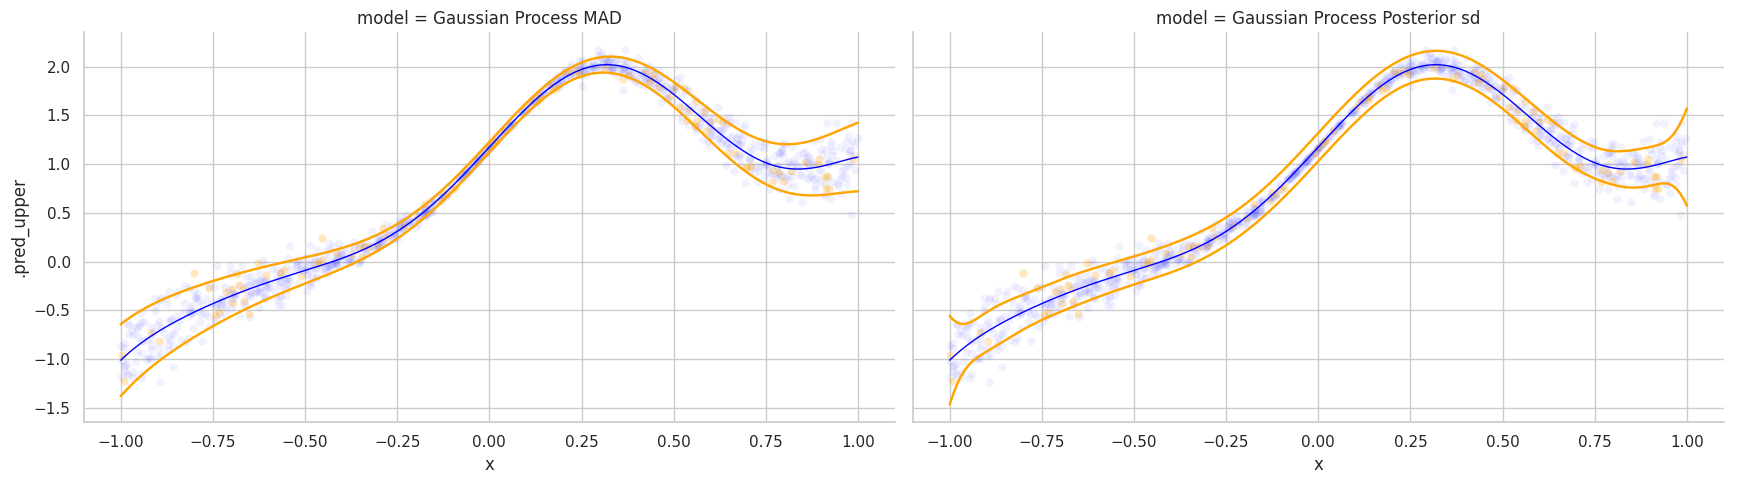

In [7]:
# Combine and visualize
model_list = {
    "Gaussian Process MAD": gp_pred,
    "Gaussian Process Posterior sd": gp_pred2,
}
all_pred = (
    pd.concat(model_list, names=["id"])
    .reset_index(level=0)
    .rename(columns={"id": "model"})
)

sns.set(style="whitegrid")
g = sns.FacetGrid(all_pred, col="model", height=5, aspect=1.75)
g.map(plt.plot, "x", ".pred", color="blue", lw=1)
g.map(plt.plot, "x", ".pred_lower", color="orange", lw=1.75)
g.map(plt.plot, "x", ".pred_upper", color="orange", lw=1.75)
for ax in g.axes.flat:
    sns.scatterplot(
        x=pretrain_data["x"], y=pretrain_data["y"], color="blue", alpha=0.05, ax=ax
    )
    sns.scatterplot(x=cal_data["x"], y=cal_data["y"], color="orange", alpha=0.25, ax=ax)

g.add_legend()

plt.show()

# Towards more complex explainability vizualization and metrics 


___________________________________________________________________________
   
                            MixedIntegerKriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.4555242
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0021806
   
   Prediction time/pt. (sec) :  0.0003634
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013773
   
   Prediction time/pt. (sec) :  0.0002296
   
___________________________________________________________________________
   
 Evaluation
   
      # 

   Predicting - done. Time (sec):  0.0022354
   
   Prediction time/pt. (sec) :  0.0003726
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0015872
   
   Prediction time/pt. (sec) :  0.0002645
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013645
   
   Prediction time/pt. (sec) :  0.0002274
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013461
   
   Prediction time/pt. (sec) :  0.0002244
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013478
   

/tmp/ipykernel_2235843/3364201701.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  a.show()


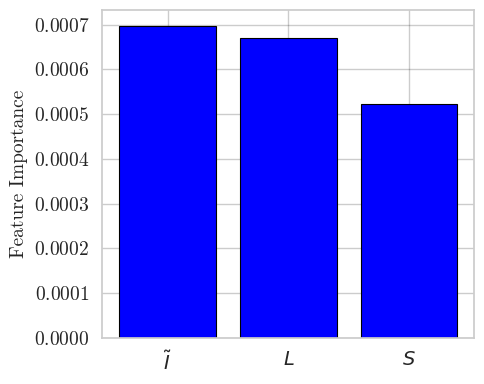

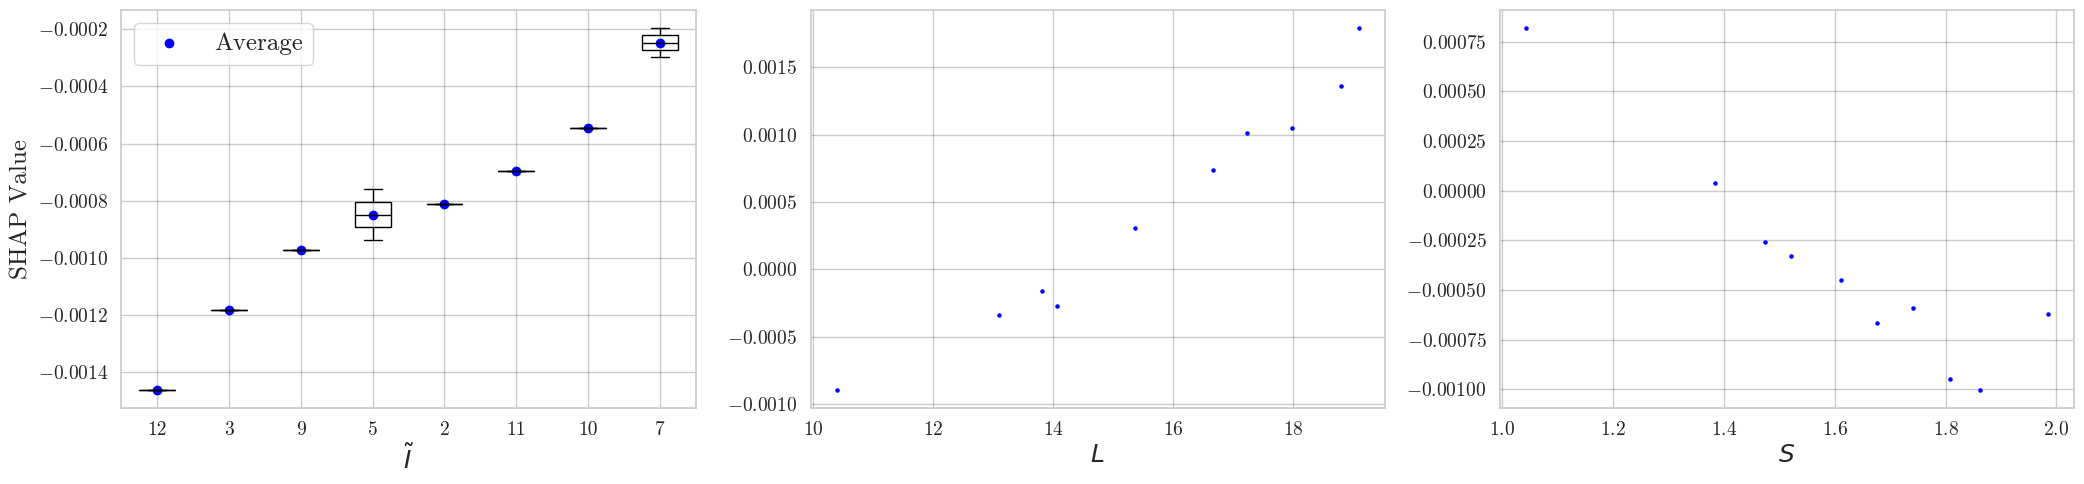

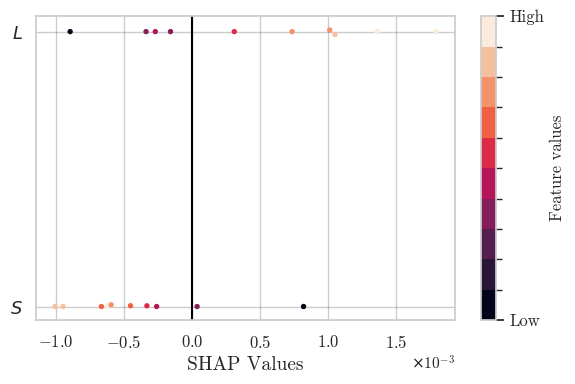

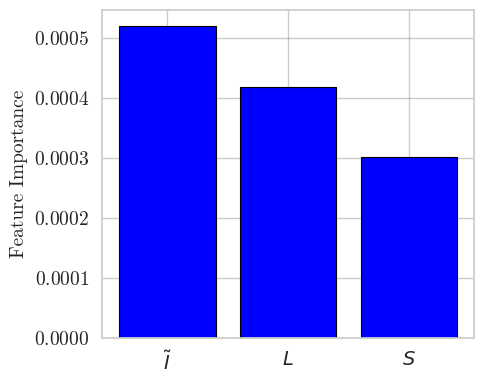

In [12]:
%matplotlib inline 
from smt.utils.sm_test_case import SMTestCase
from smt.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.sampling_methods import LHS
from smt.problems import WingWeight
from smt_ex.problems import MixedCantileverBeam
from smt_ex.shap import ShapFeatureImportanceDisplay
from smt.surrogate_models import KRG
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt_ex.shap import ShapDisplay
import numpy as np
from smt.surrogate_models import KRG, MixIntKernelType
import unittest

nsamples = 20
fun = MixedCantileverBeam()
ds = DesignSpace(
    [
        CategoricalVariable(values=[str(i + 1) for i in range(12)]),
        FloatVariable(10.0, 20.0),
        FloatVariable(1.0, 2.0),
    ]
)
x = fun.sample(nsamples)
y = fun(x)


class GroundTruthModel:
    def __init__(self, fun):
        self.fun = fun

    def predict_values(self, x):
        return self.fun(x)


# Index for categorical features
categorical_feature_indices = [0]

is_categorical = [False] * x.shape[1]
for feature_idx in categorical_feature_indices:
    is_categorical[feature_idx] = True

feature_names = [r"$\tilde{I}$", r"$L$", r"$S$"]
model = MixedIntegerKrigingModel(
    surrogate=KRG(
        design_space=ds,
        categorical_kernel=MixIntKernelType.GOWER,
        theta0=[1e-1],
        hyper_opt="Cobyla",
        corr="squar_exp",
        n_start=20,
    ),
)
model.set_training_values(x, np.array(y))
model.train()

x2 = fun.sample(nsamples * 3)

categorical_feature_indices = categorical_feature_indices
nsamples = nsamples
feature_names = feature_names
shap_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model,
    x2,
    feature_names=feature_names,
    categorical_feature_indices=categorical_feature_indices,
    method="kernel",
)
a = shap_importance.plot()

a.show()
plt.show()

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0025420
   
   Prediction time/pt. (sec) :  0.0004237
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0014307
   
   Prediction time/pt. (sec) :  0.0002385
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013654
   
   Prediction time/pt. (sec) :  0.0002276
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 6
   
   Predicting ...
   Predicting - done. Time (sec):  0.0014031
   
   Prediction time/pt. (sec) :  0.0002338
   
________________________________________________

/tmp/ipykernel_2235843/3231420137.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  b.show()
/tmp/ipykernel_2235843/3231420137.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  c.show()
/tmp/ipykernel_2235843/3231420137.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  d.show()
/tmp/ipykernel_2235843/3231420137.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  e.show()
/tmp/ipykernel_2235843/3231420137.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/tmp/ipykernel_2235843/3231420137.p

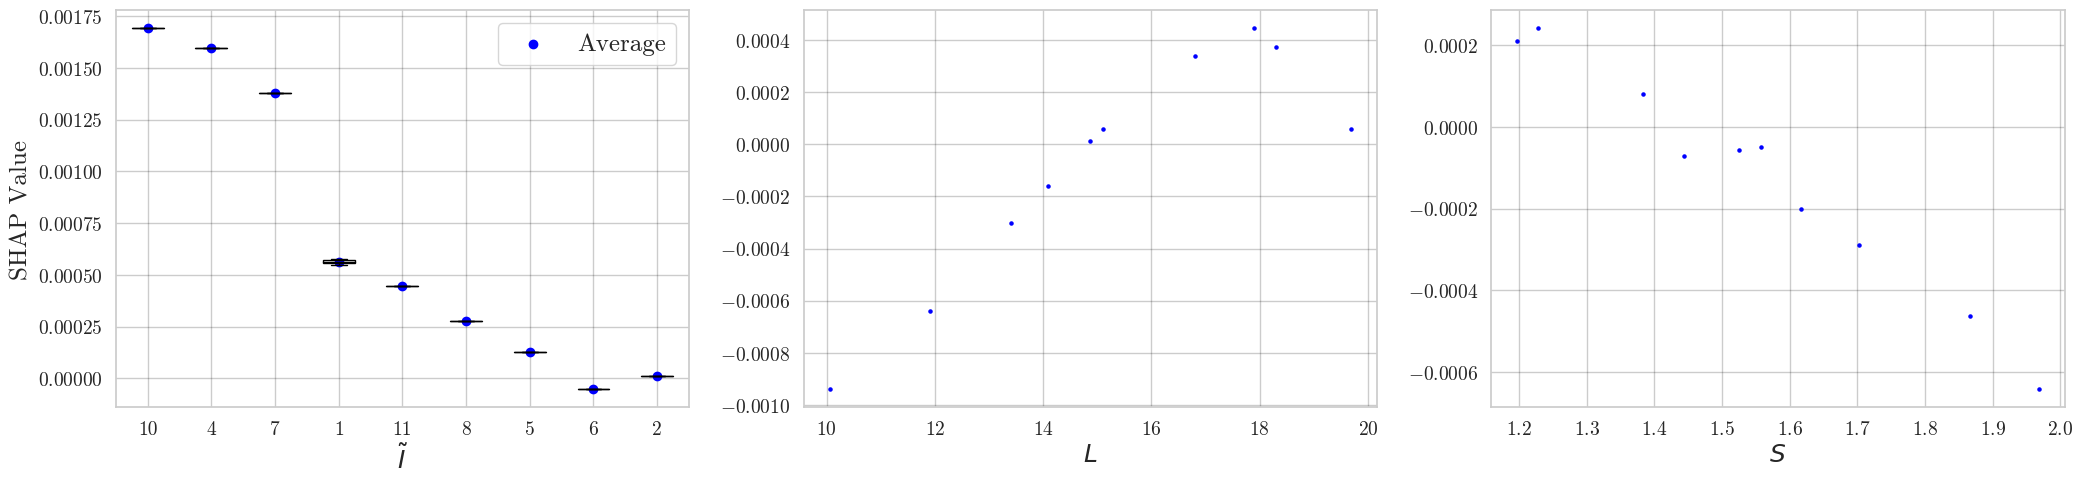

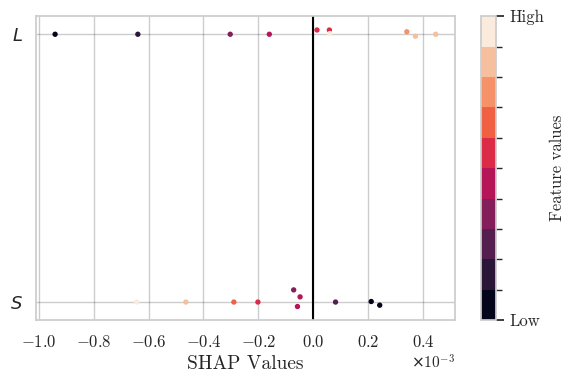

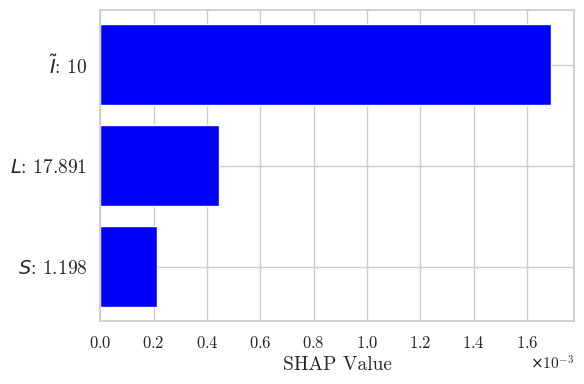

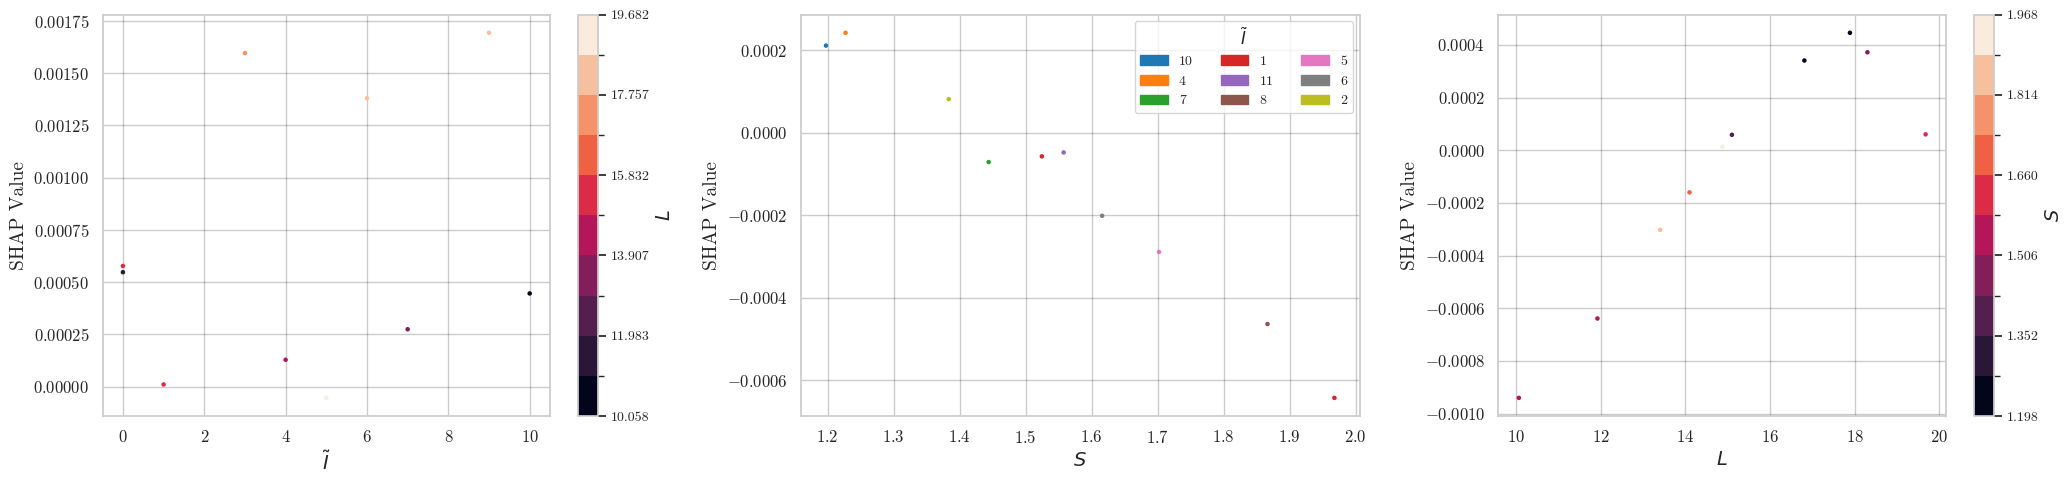

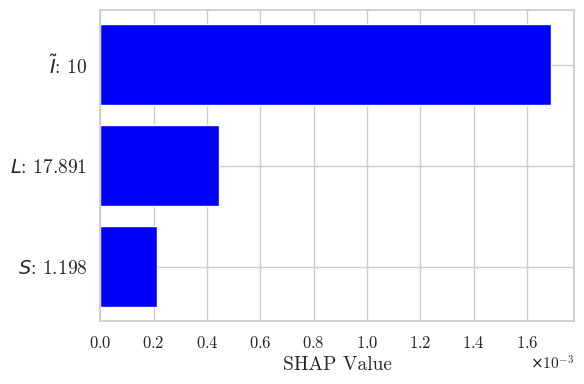

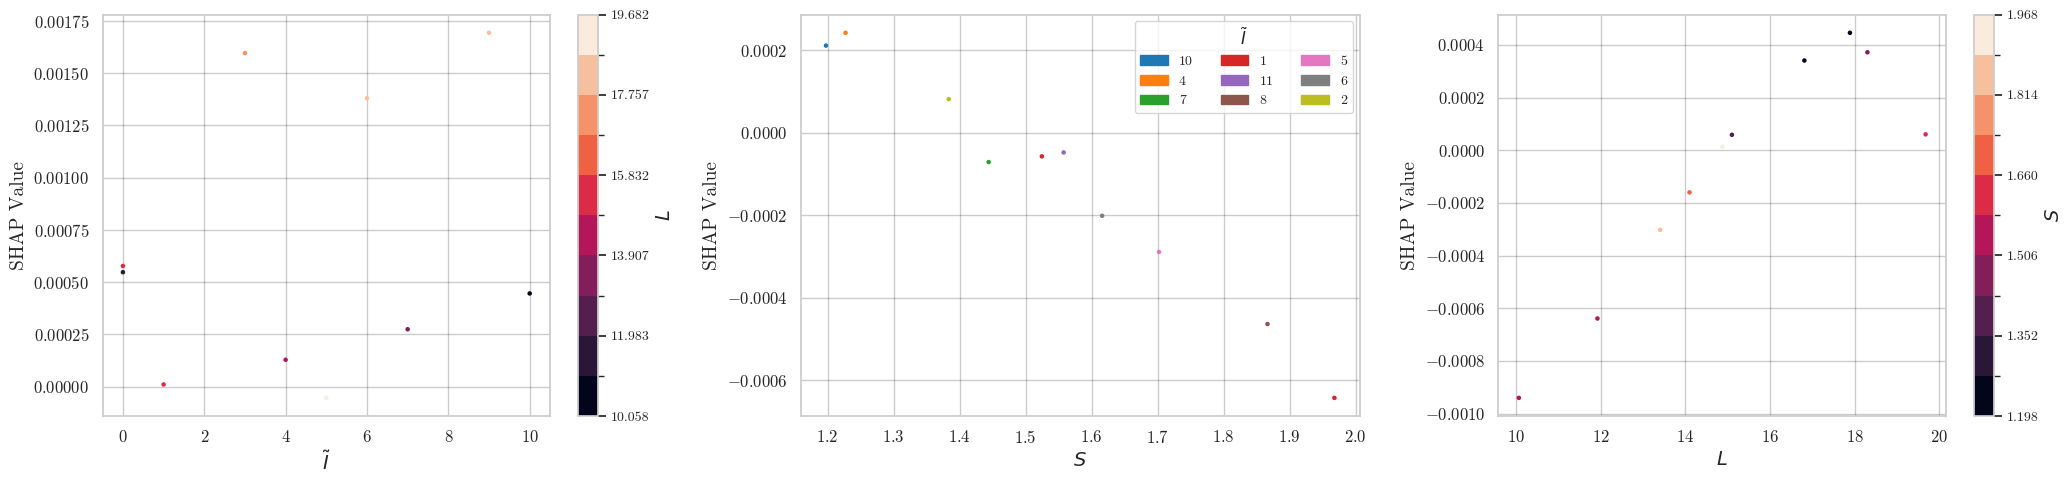

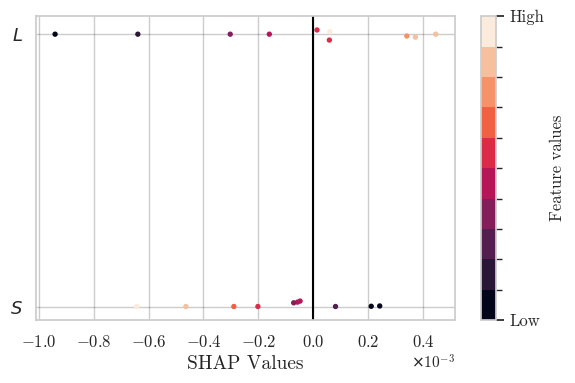

In [14]:
%matplotlib inline 

n_train = int(nsamples / 2)

x_tr, _y_tr = x[:n_train, :], y[:n_train]
x_te, _y_te = x[n_train:, :], y[n_train:]

# Index for categorical features
categorical_feature_indices = [0]
# create mapping for the categories
categories_map = dict()
is_categorical = [False] * x.shape[1]
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    is_categorical[feature_idx] = True

feature_names = [r"$\tilde{I}$", r"$L$", r"$S$"]


index_for_individual_plot = 0
feature_pairs_for_mixed_problem = [(0, 1), (2, 0), (1, 2)]

shap_explainer = ShapDisplay.from_surrogate_model(
    x_te,
    model,
    x_tr,
    feature_names=feature_names,
    categorical_feature_indices=categorical_feature_indices,
    categories_map=categories_map,
    method="kernel",
)


b = shap_explainer.dependence_plot([0, 1, 2])

b.show()

c = shap_explainer.summary_plot()
c.show()

d = shap_explainer.individual_plot(index=index_for_individual_plot)
d.show()

e = shap_explainer.interaction_plot(feature_pairs_for_mixed_problem)
e.show()

f = shap_explainer.individual_plot(index=index_for_individual_plot)
f.show()

g = shap_explainer.interaction_plot(feature_pairs_for_mixed_problem)
g.show()
h = shap_explainer.summary_plot()
h.show()